### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import torchvision as tv
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
from torchvision import transforms
import pytorch_lightning as pl
from torchmetrics import F1Score
from torchinfo import summary
from pytorch_lightning.callbacks import LearningRateFinder, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

### DATA PREPOCESS

In [2]:
START_PATH = './data'

In [3]:
df_train = pd.read_csv(f'{START_PATH}/train.csv')
df_test = pd.read_csv(f'{START_PATH}/test.csv')

In [4]:
df_train.shape, df_test.shape

((45373, 2), (19446, 1))

In [5]:
len(df_train.label.unique())

30

Посмотрим распределение меток классов в данных обучения

In [6]:
df_train.value_counts('label') / df_train.shape[0] * 100

label
basketball               5.551760
hockey                   4.740705
football                 4.738501
running                  4.388072
rugby                    4.335177
skating                  4.313138
alpinism                 4.094946
volleyball               4.090538
boxing                   3.969321
boating                  3.863531
tennis                   3.823860
horseback_riding         3.455800
handball                 3.325766
fencing                  3.131818
surfing                  3.129615
gymnastics               3.118595
golf                     3.070108
arm_wrestling            3.067904
ski_race                 2.942278
greco-Roman_wrestling    2.860732
swimming                 2.827673
sambo                    2.785798
velo                     2.680008
sailing                  2.602870
badminton                2.512507
taekwondo                2.446389
pole_vault               2.307540
archery                  2.164283
water_polo               1.873361
javelin-

In [7]:
N_LABELS = len(df_train.label.unique())

Разобьем данные на трейн и валидация с сохранением распределения целевой переменной с помощью параметра `stratify`

In [8]:
train, validation = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train.label)

In [9]:
train.shape, validation.shape

((36298, 2), (9075, 2))

Проверяем правильность разбивки данных

In [10]:
train.value_counts('label') / train.shape[0] * 100

label
basketball               5.551270
hockey                   4.741308
football                 4.738553
running                  4.388672
rugby                    4.333572
skating                  4.314287
alpinism                 4.093889
volleyball               4.091134
boxing                   3.969916
boating                  3.862472
tennis                   3.823902
horseback_riding         3.454736
handball                 3.325252
fencing                  3.132404
surfing                  3.129649
gymnastics               3.118629
golf                     3.069040
arm_wrestling            3.069040
ski_race                 2.942311
greco-Roman_wrestling    2.859662
swimming                 2.826602
sambo                    2.785277
velo                     2.680588
sailing                  2.603449
badminton                2.512535
taekwondo                2.446416
pole_vault               2.308667
archery                  2.165409
water_polo               1.873381
javelin-

In [11]:
validation.value_counts('label') / validation.shape[0] * 100

label
basketball               5.553719
hockey                   4.738292
football                 4.738292
running                  4.385675
rugby                    4.341598
skating                  4.308540
alpinism                 4.099174
volleyball               4.088154
boxing                   3.966942
boating                  3.867769
tennis                   3.823691
horseback_riding         3.460055
handball                 3.327824
fencing                  3.129477
surfing                  3.129477
gymnastics               3.118457
golf                     3.074380
arm_wrestling            3.063361
ski_race                 2.942149
greco-Roman_wrestling    2.865014
swimming                 2.831956
sambo                    2.787879
velo                     2.677686
sailing                  2.600551
badminton                2.512397
taekwondo                2.446281
pole_vault               2.303030
archery                  2.159780
water_polo               1.873278
javelin-

Посмотрим картинку из каждого класса обучающей выборки

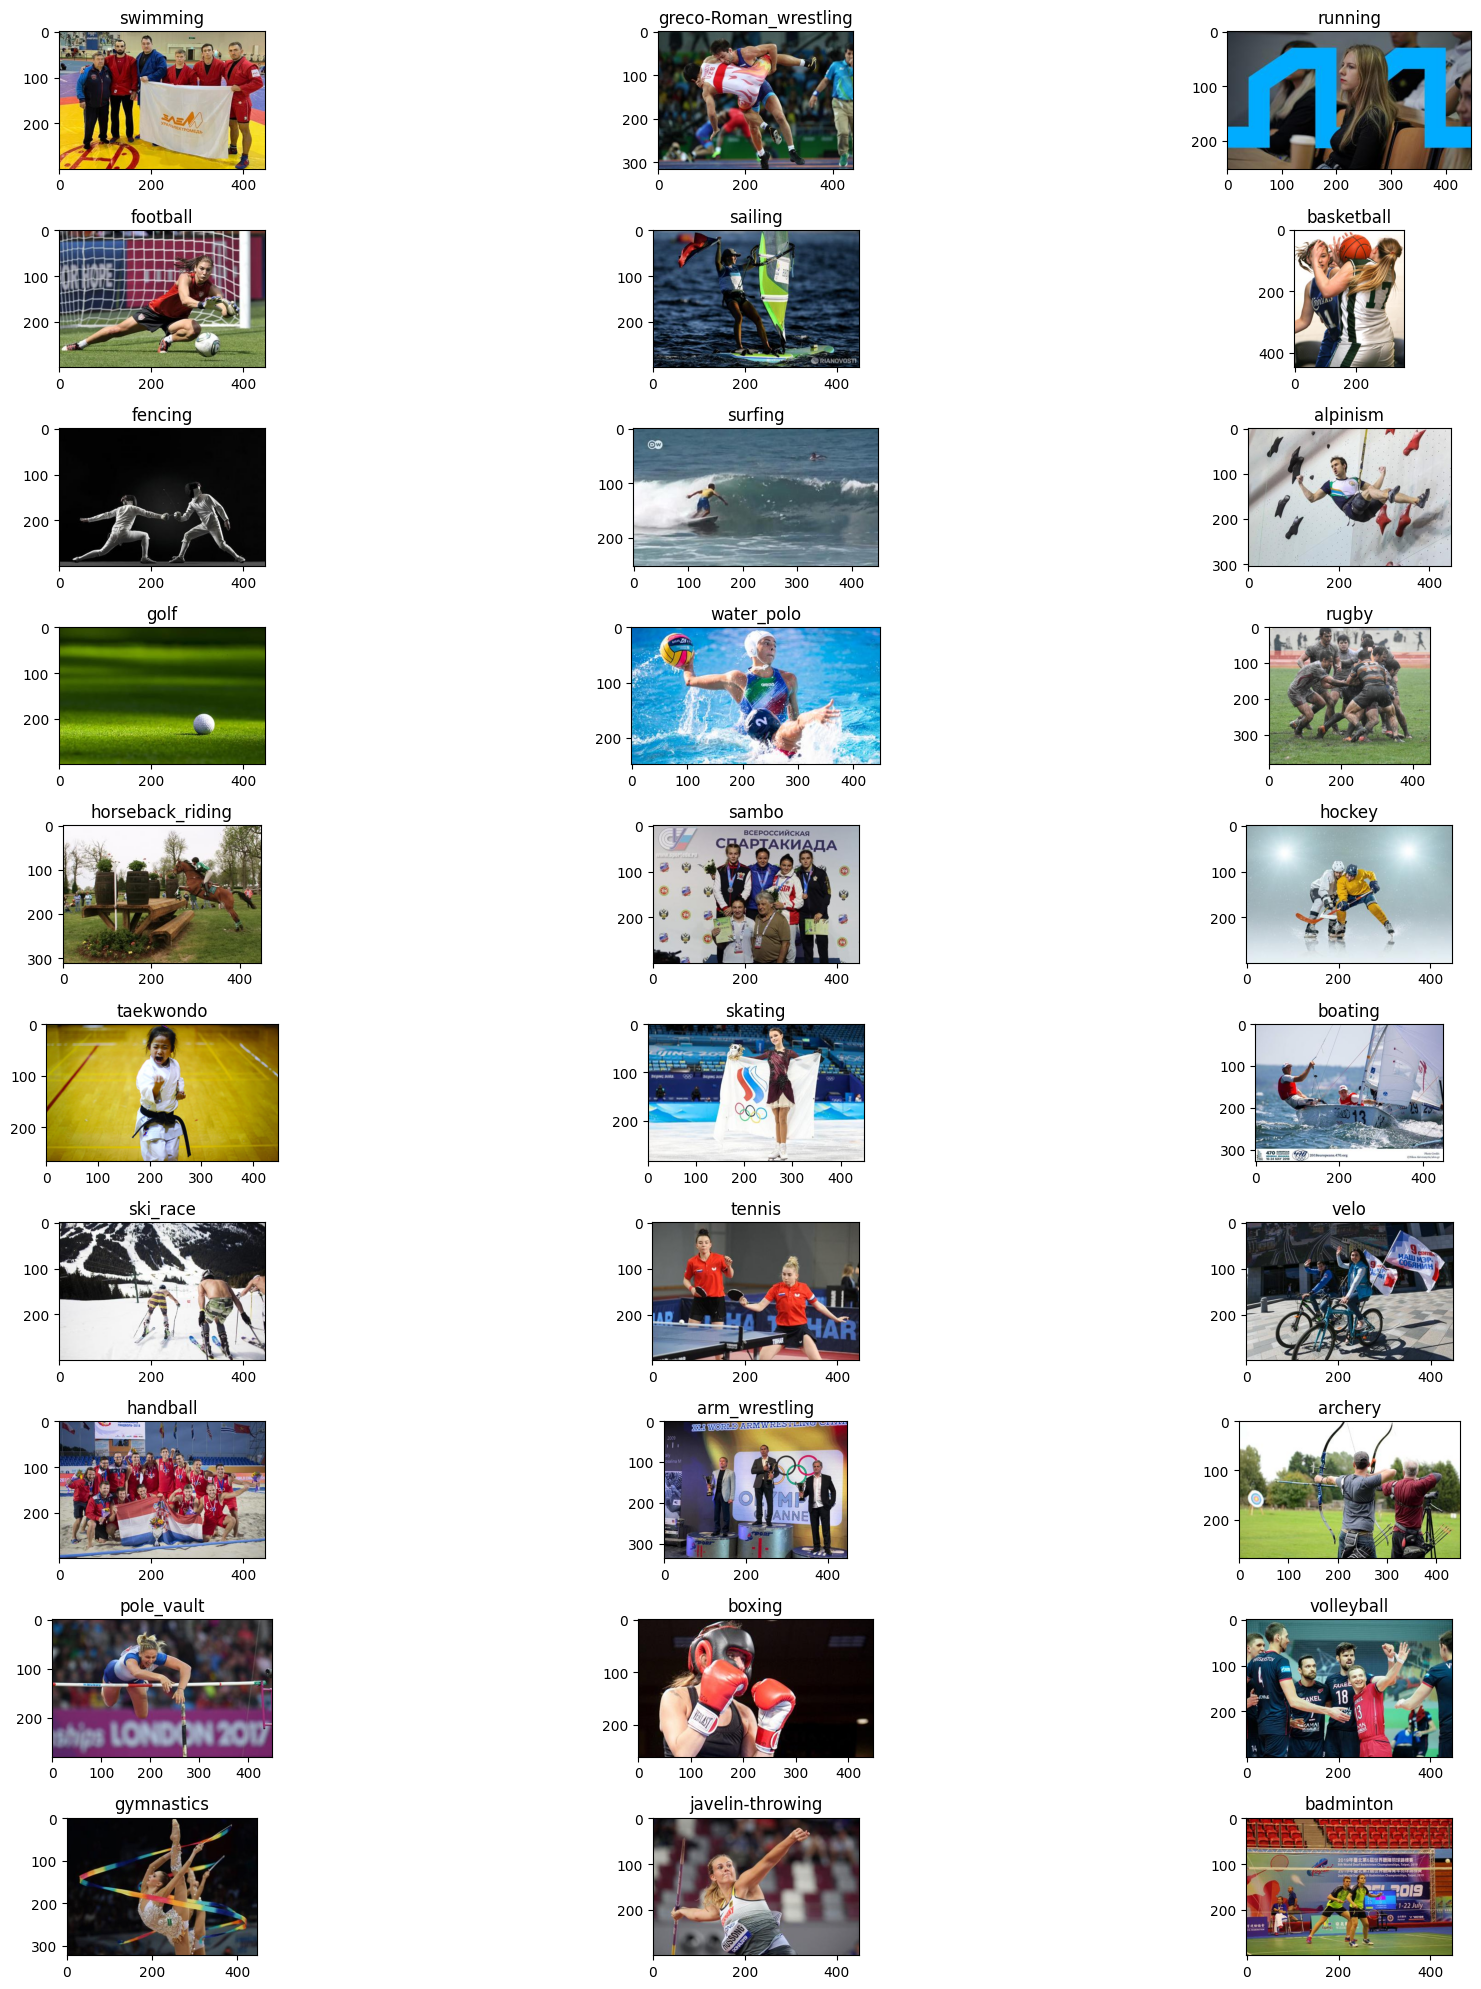

In [13]:
fig, ax = plt.subplots(10, 3, figsize=(20, 20))
for index, label in enumerate(df_train.label.unique()):
    image_info = df_train[df_train['label'] == label].sample(1)
    im = Image.open(f'{START_PATH}/train/{image_info.iloc[0, 0]}').convert("RGB")
    ax[index // 3, index % 3].imshow(im)
    ax[index // 3, index % 3].set_title(label)
fig.tight_layout()
plt.show()

### DATASET

Создаим маппинг классов в цифры и наоборот

In [14]:
label_to_index = {}
index_to_label = {}
for index, label in enumerate(df_train.label.unique()):
    label_to_index[label] = index
    index_to_label[index] = label

In [15]:
label_to_index

{'swimming': 0,
 'greco-Roman_wrestling': 1,
 'running': 2,
 'football': 3,
 'sailing': 4,
 'basketball': 5,
 'fencing': 6,
 'surfing': 7,
 'alpinism': 8,
 'golf': 9,
 'water_polo': 10,
 'rugby': 11,
 'horseback_riding': 12,
 'sambo': 13,
 'hockey': 14,
 'taekwondo': 15,
 'skating': 16,
 'boating': 17,
 'ski_race': 18,
 'tennis': 19,
 'velo': 20,
 'handball': 21,
 'arm_wrestling': 22,
 'archery': 23,
 'pole_vault': 24,
 'boxing': 25,
 'volleyball': 26,
 'gymnastics': 27,
 'javelin-throwing': 28,
 'badminton': 29}

In [16]:
index_to_label

{0: 'swimming',
 1: 'greco-Roman_wrestling',
 2: 'running',
 3: 'football',
 4: 'sailing',
 5: 'basketball',
 6: 'fencing',
 7: 'surfing',
 8: 'alpinism',
 9: 'golf',
 10: 'water_polo',
 11: 'rugby',
 12: 'horseback_riding',
 13: 'sambo',
 14: 'hockey',
 15: 'taekwondo',
 16: 'skating',
 17: 'boating',
 18: 'ski_race',
 19: 'tennis',
 20: 'velo',
 21: 'handball',
 22: 'arm_wrestling',
 23: 'archery',
 24: 'pole_vault',
 25: 'boxing',
 26: 'volleyball',
 27: 'gymnastics',
 28: 'javelin-throwing',
 29: 'badminton'}

Создадим класс датасет для чтения исходных данных в память, а затем создания loader 

In [17]:
class SportDataset(Dataset):

    def __init__(self, dataframe, image_transformer=None):
        self.image_transformer = image_transformer
        self.dataframe = dataframe
        print("reading data")
        self._read_all_data()
        print("data read")
        
    def _read_all_data(self):
        self.images = {}
        for i in range(self.dataframe.shape[0]):
            image_name = self.dataframe.iloc[i].image_id
            image = Image.open(f'{START_PATH}/train/{image_name}').convert("RGB")
            if self.image_transformer:
                image = self.image_transformer(image)
            self.images[image_name] = image
            if i % 10_000 == 0:
                print(i)

    def __getitem__(self, index):
        image_name = self.dataframe.iloc[index].image_id
        label = label_to_index[self.dataframe.iloc[index].label]
        
        return self.images[image_name], label

    def __len__(self):
        return self.dataframe.shape[0]

Создадим свою предобработку изобращений:
- Изменение размеров изображения
- Обрезание изображения под входные данные модели
- С вероятностью 25% вращаем изображение на угол из диапазона (-30;+30) градусов
- Добавление размытия Гаусса
- Добавление рандомного изменения яркости, контрастности, насыщенности и оттенка изображения
- Преобразование изображения к тензору
- И нормализация изображения с помощью данных из EfficientNetImageProcessor

In [18]:
my_aug = tv.transforms.Compose([
    tv.transforms.Resize(size=320, interpolation=tv.transforms.InterpolationMode("bicubic"), max_size=None, antialias=None),
    tv.transforms.CenterCrop(size=(300, 300)),
    tv.transforms.RandomApply([tv.transforms.RandomRotation(degrees=30)], p=0.25),
    tv.transforms.RandomHorizontalFlip(p=0.25),
    tv.transforms.GaussianBlur(5),
    tv.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=torch.tensor([0.485, 0.456, 0.406]), std=torch.tensor([0.47853944, 0.4732864, 0.47434163])),
])

### Model on Efficient Net

Источники для моделей и референсного кода: 
- https://huggingface.co/google/efficientnet-b3 - Архитектура и предобученная модель
- https://www.pytorchlightning.ai/index.html - Пример по написанию PytorchLightning модуля

In [314]:
from transformers import EfficientNetImageProcessor, EfficientNetForImageClassification

preprocessor = EfficientNetImageProcessor.from_pretrained("./efficientnet-b3")

In [435]:
preprocessor.image_mean

[0.485, 0.456, 0.406]

In [436]:
preprocessor.image_std

[0.47853944, 0.4732864, 0.47434163]

In [322]:
model = EfficientNetForImageClassification.from_pretrained("./efficientnet-b3", return_dict=False)

In [326]:
model.efficientnet(i)[0].shape

torch.Size([32, 1536, 7, 7])

In [328]:
my_net(i).shape

torch.Size([32, 30])

In [21]:
class MyNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        model = EfficientNetForImageClassification.from_pretrained("./efficientnet-b3", return_dict=False)
        
        # Замораживаем слои, которые извлекают признаки из изображений
        self.freezed_layers = nn.Sequential(*list(model.children())[:-3])
        
        # Добавление кастомного классификатора
        self.training_layers = nn.Sequential(
            nn.Dropout(0.3),
            nn.BatchNorm1d(1536),
            nn.Linear(1536, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, N_LABELS)
        )
        
        # Отключение расчета градиентов при forward 
        self.freezed_layers.eval()
        for param in self.freezed_layers.parameters():
            param.requires_grad = False
            
        self.learning_rate = 1e-4
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_metric = F1Score(task="multiclass", num_classes=N_LABELS)
        self.val_metric = F1Score(task="multiclass", num_classes=N_LABELS)
    
    def forward(self, x):
        self.freezed_layers.eval()
        with torch.no_grad():
            x = self.freezed_layers(x)[1]
        x = self.training_layers(x)
        return x
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return opt
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.train_metric(logits, y)
        self.log('train_score', self.train_metric, on_epoch=True, prog_bar=True, on_step=False)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.val_metric(logits, y)
        self.log('validation_score', self.val_metric, on_epoch=True, prog_bar=True, on_step=False)
        

In [22]:
my_net = MyNet().to(1)

In [23]:
summary(my_net , input_size=(32, 3, 300, 300))

Layer (type:depth-idx)                                                 Output Shape              Param #
MyNet                                                                  [32, 30]                  --
├─Sequential: 1-1                                                      [32, 1536, 10, 10]        --
│    └─EfficientNetModel: 2-1                                          [32, 1536, 10, 10]        --
│    │    └─EfficientNetEmbeddings: 3-1                                [32, 40, 150, 150]        (1,160)
│    │    └─EfficientNetEncoder: 3-2                                   [32, 1536, 10, 10]        (10,695,072)
│    │    └─AvgPool2d: 3-3                                             [32, 1536, 1, 1]          --
├─Sequential: 1-2                                                      [32, 30]                  --
│    └─Dropout: 2-2                                                    [32, 1536]                --
│    └─BatchNorm1d: 2-3                                                [32, 1536

In [25]:
%%time
train_set = SportDataset(train, my_aug)
validation_set = SportDataset(validation, my_aug)

reading data
0
10000
20000
30000
data read
reading data
0
data read
CPU times: user 14h 12min 50s, sys: 8min 49s, total: 14h 21min 39s
Wall time: 18min 29s


In [49]:
BATCH_SIZE = 32

Добавление взвешенного семплирования в соответствие с распределением классов

In [58]:
class_counts = train.label.value_counts()
sample_weights = [1 / class_counts[i] for i in train.label]
weighted_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train), replacement=True)

In [59]:
train_batch_gen = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=8, sampler=weighted_sampler)
val_batch_gen = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

In [60]:
logger = pl.loggers.CSVLogger(save_dir='.', version="MyEfficientNet")
lr_finder = LearningRateFinder()
checkpoint_callback = ModelCheckpoint(
    monitor='validation_score', 
    mode='max', 
    dirpath="models/EfficientNet/", 
    filename="MyEfficientNet-{validation_score:.3f}"
)
early_stopping = EarlyStopping(monitor="validation_score", mode="max", patience=5)

In [61]:
trainer = pl.Trainer(
    max_epochs=50, 
    accelerator="gpu", 
    devices=[1], 
    callbacks=[checkpoint_callback, early_stopping, lr_finder], 
    log_every_n_steps=50, 
    logger=logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    my_net,
    train_dataloaders=train_batch_gen,
    val_dataloaders=val_batch_gen
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 89 steps due to diverging loss.
Restoring states from the checkpoint path at /data/home/makhisamu1/000_CV_MADE_CONTEST/.lr_find_2fe3f7cf-96f2-4e29-ba3e-0dce7f8ef597.ckpt
Restored all states from the checkpoint file at /data/home/makhisamu1/000_CV_MADE_CONTEST/.lr_find_2fe3f7cf-96f2-4e29-ba3e-0dce7f8ef597.ckpt

  | Name            | Type              | Params
------------------------------------------------------
0 | freezed_layers  | Sequential        | 10.7 M
1 | training_layers | Sequential        | 404 K 
2 | loss_fn         | CrossEntropyLoss  | 0     
3 | train_metric    | MulticlassF1Score | 0     
4 | val_metric      | MulticlassF1Score | 0     
------------------------------------------------------
404 K     Trainable params
10.7 M    Non-trainable params
11.1 M    Total params
44.404    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [67]:
trainer.save_checkpoint("models/EfficientNet/Manual_check.ckpt")

Посмотрм что предсказывает обученная EfficientNet на валидационной выборке

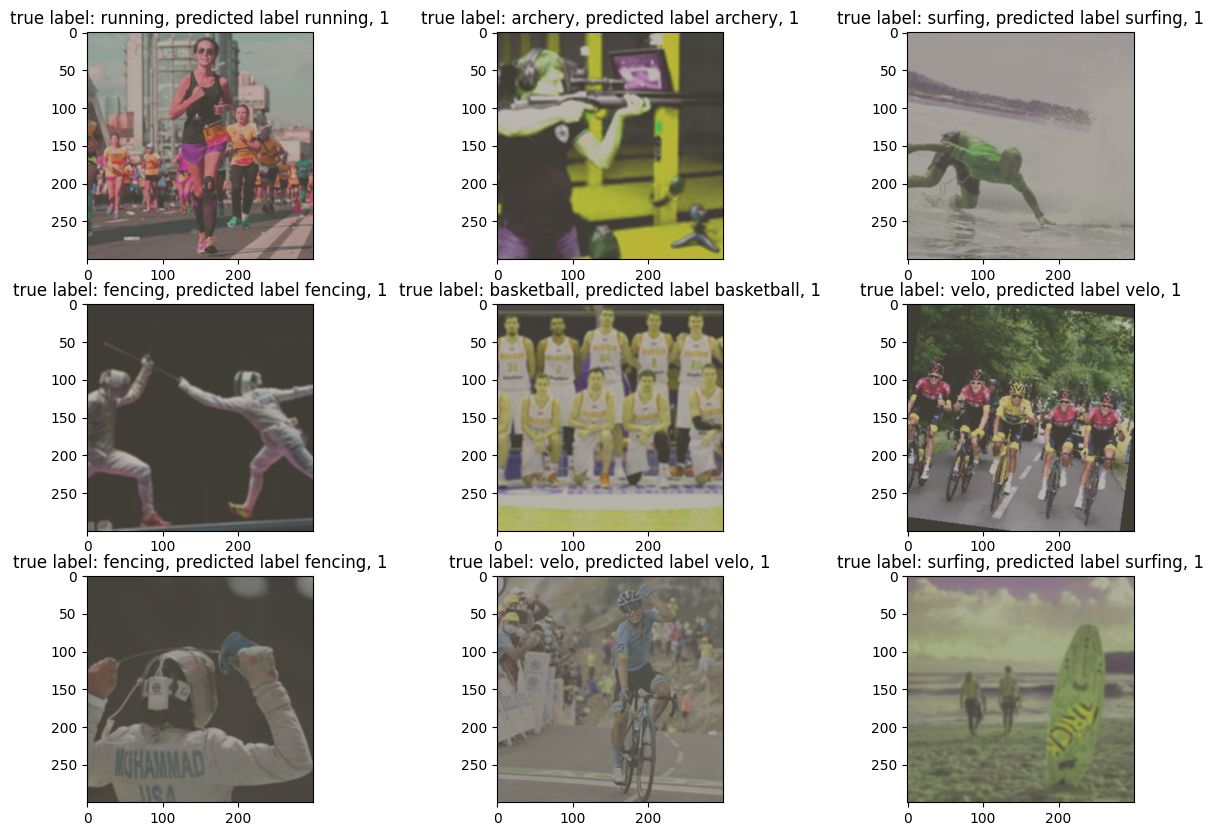

In [86]:
f, ax = plt.subplots(3, 3)
f.set_size_inches(15,10)
my_net.eval()
with torch.no_grad():
    for i, index in enumerate(np.random.choice(len(validation_set), 9)):
        image, label = validation_set[index]
        image = image.cuda()
        logits = my_net(image[None, :])
        indx = torch.argmax(logits).item()
        res = index_to_label[indx]

        image = np.transpose(image.cpu().numpy(), [1, 2, 0])
        src = np.array([0.2290, 0.2240, 0.2250]) * image + np.array([0.4850, 0.4560, 0.4060])
        ax[i // 3, i % 3].imshow(src)
        ax[i // 3, i % 3].set_title(f'true label: {index_to_label[label]}, predicted label {res}, {int(index_to_label[label] == res)}')

Модифицируем класс загрузчик под тестовые данные (изменена папка и отсутствие возврата label)

In [96]:
class SportDatasetTest(Dataset):

    def __init__(self, dataframe, image_transformer=None):
        self.image_transformer = image_transformer
        self.dataframe = dataframe
        print("reading data")
        self._read_all_data()
        print("data read")
        
    def _read_all_data(self):
        self.images = {}
        for i in range(self.dataframe.shape[0]):
            image_name = self.dataframe.iloc[i].image_id
            image = Image.open(f'{START_PATH}/test/{image_name}').convert("RGB")
            if self.image_transformer:
                image = self.image_transformer(image)
            self.images[image_name] = image
            if i % 10_000 == 0:
                print(i)

    def __getitem__(self, index):
        image_name = self.dataframe.iloc[index].image_id        
        return self.images[image_name]

    def __len__(self):
        return self.dataframe.shape[0]

In [97]:
test_set = SportDatasetTest(df_test, my_aug)

reading data
0
10000
data read


In [98]:
test_batch_gen = DataLoader(test_set, batch_size=128, num_workers=8, shuffle=False)

In [99]:
from tqdm import tqdm

In [100]:
predictions = []
my_net.eval()
with torch.no_grad():
    for tensor in tqdm(test_batch_gen, total=len(test_set) // 128):
        tensor = tensor.cuda()
        logits = my_net(tensor)
        indxes = torch.argmax(logits, dim=1)
        for indx in indxes:
            res = index_to_label[indx.item()]
            predictions.append(res)

152it [01:06,  2.29it/s]                         


In [101]:
df_test['label'] = predictions

In [102]:
df_test.to_csv('prediction_efficient_net.csv', index=False)

Ради интереса посмотрим что предсказывает модель на тестовых данных для каждого класса

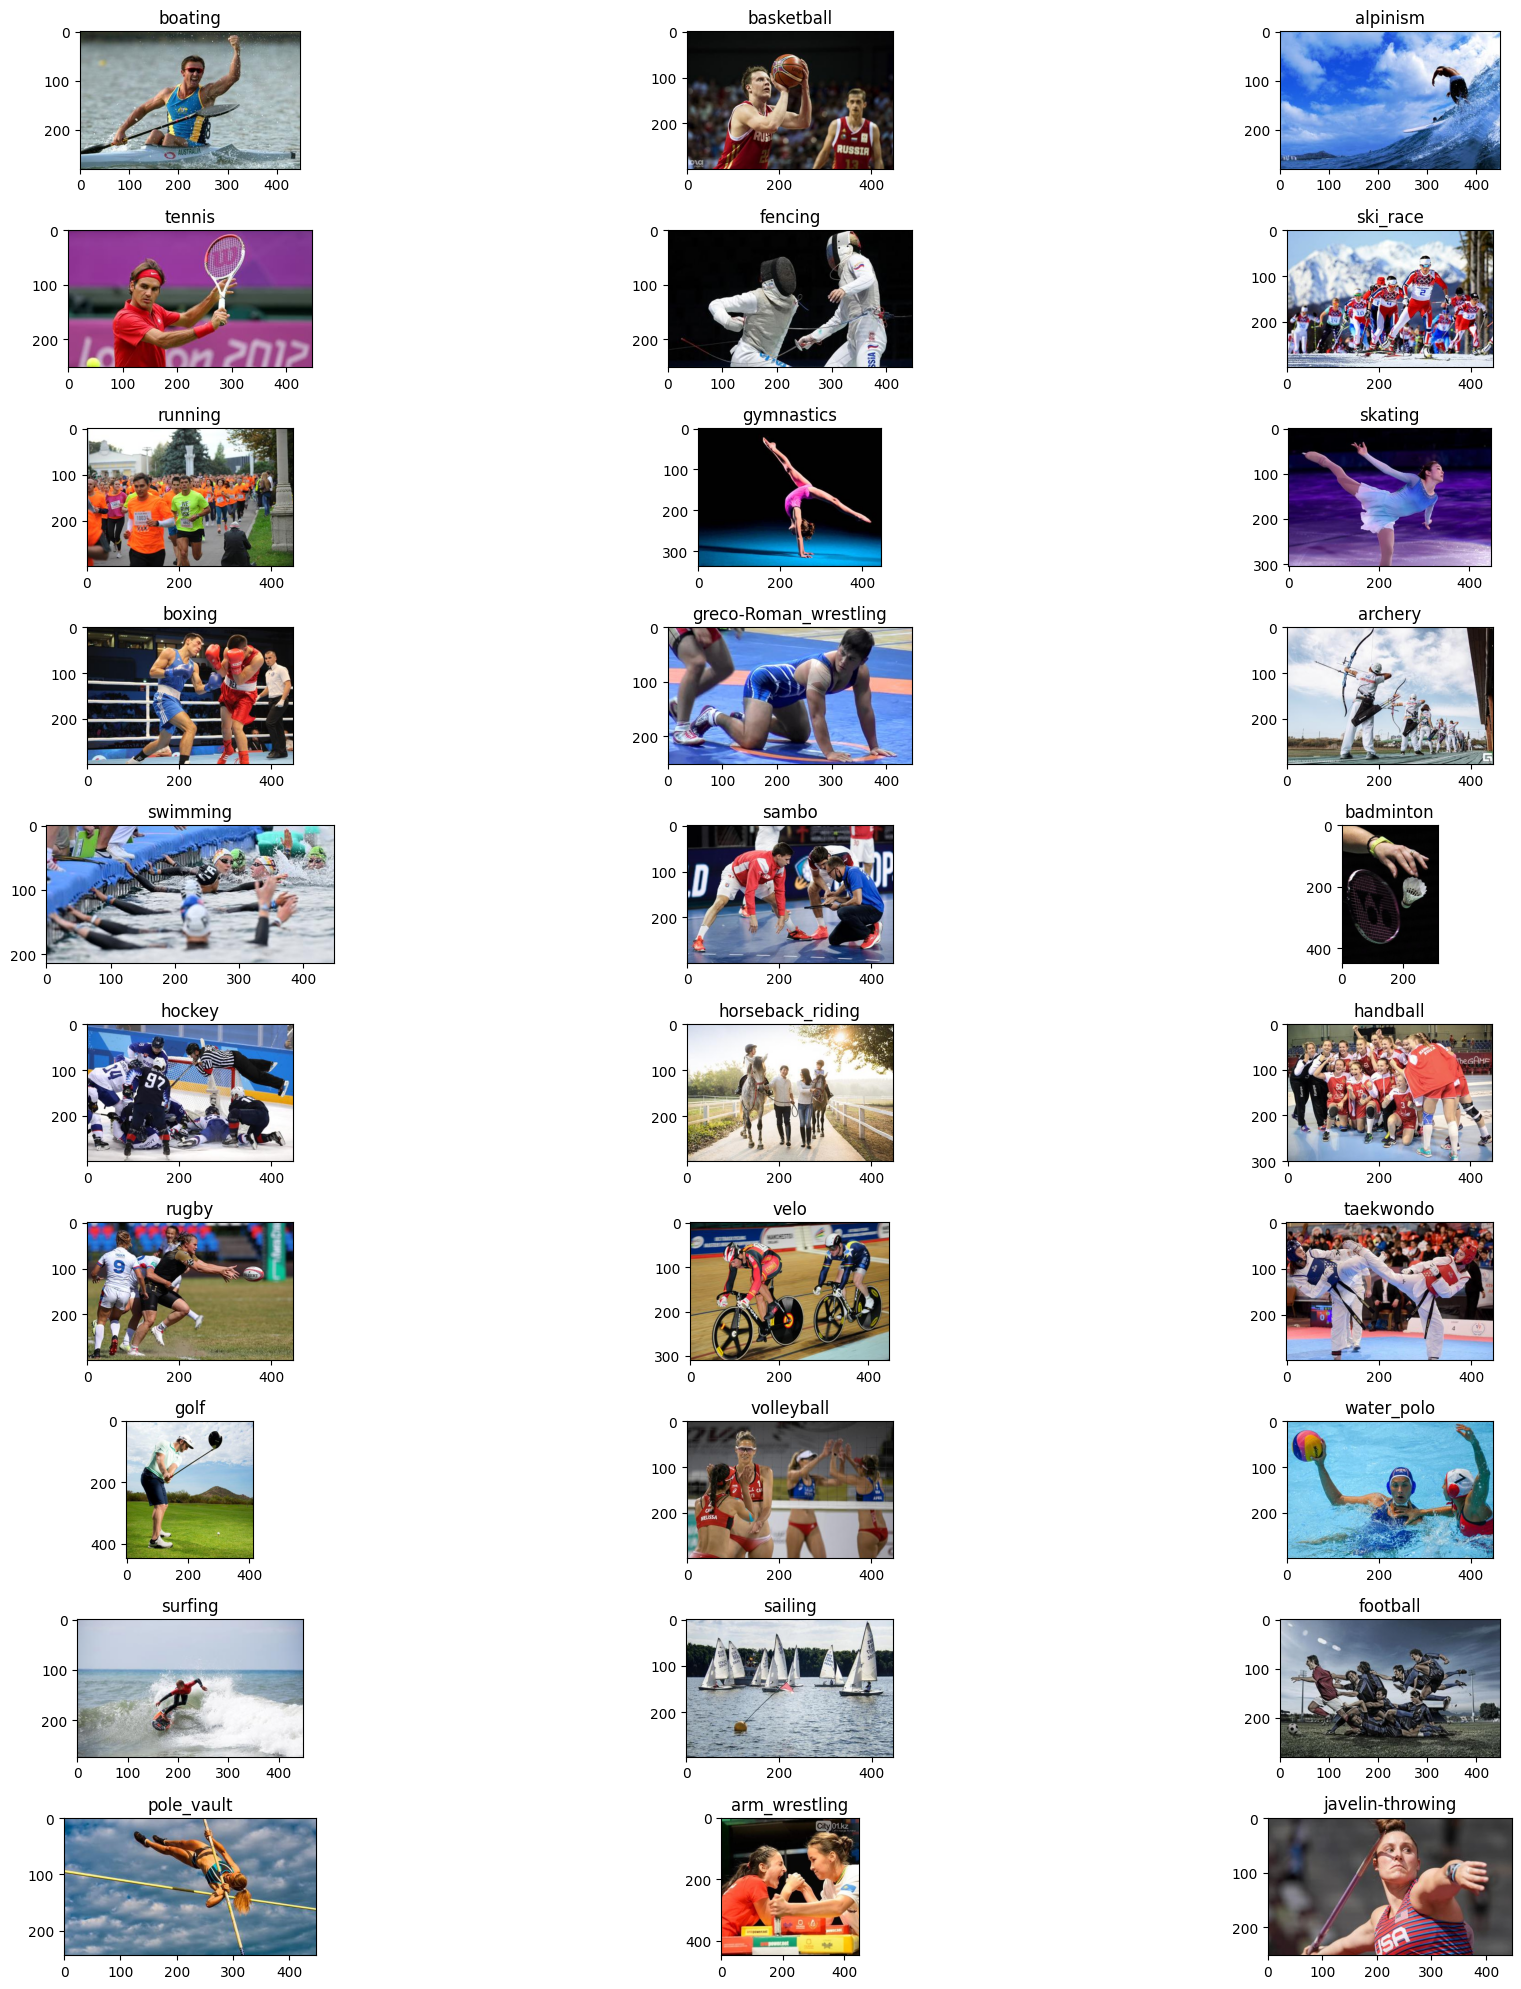

In [104]:
fig, ax = plt.subplots(10, 3, figsize=(20, 20))
for index, label in enumerate(df_test.label.unique()):
    image_info = df_test[df_test['label'] == label].sample(1)
    im = Image.open(f'{START_PATH}/test/{image_info.iloc[0, 0]}').convert("RGB")
    ax[index // 3, index % 3].imshow(im)
    ax[index // 3, index % 3].set_title(label)
fig.tight_layout()
plt.show()

### ViT

Попробуем предобученный трансформер

Источники:
- https://huggingface.co/google/vit-base-patch16-224

In [331]:
from transformers import ViTImageProcessor, ViTForImageClassification

feature_extractor = ViTImageProcessor.from_pretrained('./vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('./vit-base-patch16-224', return_dict=False)

Создание нового класса для чтения данных - подходит под чтение обучающей и тестовой выборки

In [165]:
class SportDatasetVit(Dataset):

    def __init__(self, dataframe, image_transformer=None, is_train=True):
        self.image_transformer = image_transformer
        self.dataframe = dataframe
        self.is_train = is_train
        print("reading data")
        self._read_all_data()
        print("data read")
        
    def _read_all_data(self):
        self.images = {}
        source = 'train' if self.is_train else 'test'
        for i in range(self.dataframe.shape[0]):
            image_name = self.dataframe.iloc[i].image_id
            image = Image.open(f'{START_PATH}/{source}/{image_name}').convert("RGB")
            if self.image_transformer:
                image = self.image_transformer(image, return_tensors="pt")['pixel_values'].squeeze()
            self.images[image_name] = image
            if i % 10_000 == 0:
                print(i)

    def __getitem__(self, index):
        image_name = self.dataframe.iloc[index].image_id  
        if self.is_train:
            label = label_to_index[self.dataframe.iloc[index].label]
            return self.images[image_name], label
        else:
            return self.images[image_name]

    def __len__(self):
        return self.dataframe.shape[0]

In [166]:
%%time
train_set = SportDatasetVit(train, feature_extractor)
validation_set = SportDatasetVit(validation, feature_extractor)

reading data
0
10000
20000
30000
data read
reading data
0
data read
CPU times: user 5h 45min 46s, sys: 4min 31s, total: 5h 50min 17s
Wall time: 6min 24s


In [350]:
class MyViT(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = ViTForImageClassification.from_pretrained('./vit-base-patch16-224', return_dict=False)
        
        # Добавление собственного классификатора
        self.model.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, N_LABELS)
        )
        
        # Отключение обучения у трансформера
        self.model.vit.eval()
        for param in self.model.vit.parameters():
            param.requires_grad = False
            
        self.learning_rate = 1e-3
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_metric = F1Score(task="multiclass", num_classes=N_LABELS)
        self.val_metric = F1Score(task="multiclass", num_classes=N_LABELS)
    
    def forward(self, x):
        self.model.vit.eval()
        with torch.no_grad():
            x = self.model.vit(x)[0]
        x = self.model.classifier(x[:, 0, :])
        return x
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return opt
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.train_metric(logits, y)
        self.log('train_score', self.train_metric, on_epoch=True, prog_bar=True, on_step=False)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.val_metric(logits, y)
        self.log('validation_score', self.val_metric, on_epoch=True, prog_bar=True, on_step=False)
        

In [351]:
my_vit = MyViT()

In [352]:
summary(my_vit , input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                                       Output Shape              Param #
MyViT                                                        [32, 30]                  --
├─ViTForImageClassification: 1-1                             --                        --
│    └─ViTModel: 2-1                                         [32, 197, 768]            --
│    │    └─ViTEmbeddings: 3-1                               [32, 197, 768]            (742,656)
│    │    └─ViTEncoder: 3-2                                  [32, 197, 768]            (85,054,464)
│    │    └─LayerNorm: 3-3                                   [32, 197, 768]            (1,536)
│    └─Sequential: 2-2                                       [32, 30]                  --
│    │    └─Linear: 3-4                                      [32, 512]                 393,728
│    │    └─ReLU: 3-5                                        [32, 512]                 --
│    │    └─Dropout: 3-6                                     [32, 51

In [353]:
BATCH_SIZE = 32

In [354]:
class_counts = train.label.value_counts()
sample_weights = [1 / class_counts[i] for i in train.label]
weighted_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train), replacement=True)

In [355]:
train_batch_gen = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=8, sampler=weighted_sampler)
val_batch_gen = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

In [356]:
logger = pl.loggers.CSVLogger(save_dir='.', version="MyViT-16-224")
lr_finder = LearningRateFinder()
checkpoint_callback = ModelCheckpoint(
    monitor='validation_score', 
    mode='max', 
    dirpath="models/MyViT-16-224/", 
    filename="MyViT-16-224-{validation_score:.3f}"
)
early_stopping = EarlyStopping(monitor="validation_score", mode="max", patience=5)

In [358]:
trainer = pl.Trainer(
    min_epochs=20,
    max_epochs=100, 
    accelerator="gpu", 
    devices=[1], 
    callbacks=[checkpoint_callback, early_stopping, lr_finder], 
    log_every_n_steps=50, 
    logger=logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [359]:
trainer.fit(
    my_vit,
    train_dataloaders=train_batch_gen,
    val_dataloaders=val_batch_gen
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Trainer was signaled to stop but the required `min_epochs=20` or `min_steps=None` has not been met. Training will continue...
`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /data/home/makhisamu1/000_CV_MADE_CONTEST/.lr_find_731cb8b0-c7b1-4ac7-8066-2777084316f7.ckpt
Restored all states from the checkpoint file at /data/home/makhisamu1/000_CV_MADE_CONTEST/.lr_find_731cb8b0-c7b1-4ac7-8066-2777084316f7.ckpt

  | Name         | Type                      | Params
-----------------------------------------------------------
0 | model        | ViTForImageClassification | 86.2 M
1 | loss_fn      | CrossEntropyLoss          | 0     
2 | train_metric | MulticlassF1Score         | 0     
3 | val_metric   | MulticlassF1Score         | 0     
-----------------------------------------------------------
409 K     Trainable params
85.8 M    Non-trainable params
86.2 M    Total params
344.831   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Получилось две версии трансформера - лучшая версия, судя по валидационной выборке и чуть еще переобученная версия на обучающей выборке

In [437]:
logs = pd.read_csv('./lightning_logs/MyViT-16-224/metrics.csv')

In [438]:
logs.groupby('epoch').mean()

train_loss_step          step  train_loss  validation_score  \
epoch                                                                
0             0.309231    620.666667    0.296323          0.915313   
1             0.192563   1744.600000    0.286052          0.924688   
2             0.253522   2893.400000    0.311192          0.922188   
3             0.178655   4021.083333    0.305263          0.927188   
4             0.136698   5145.000000    0.349553          0.917500   
5             0.118471   6293.800000    0.327516          0.928750   
6             0.133946   7421.500000    0.348700          0.927188   
7             0.077412   8545.400000    0.366864          0.926562   
8             0.045440   9694.200000    0.390583          0.926250   
9             0.080185  10843.000000    0.422624          0.925625   
10            0.088697  11970.666667    0.432205          0.927188   
11            0.086626  13052.997361    0.429857          0.922813   
12            0.081429  14187.997361    0.444379          0.925000   
13            0.068629  15322.997361    0.461251          0.925625   
14            0.069786  16457.997361    0.474034          0.927188   
15            0.063313  17592.997361    0.532584          0.927188   
16            0.066485  18727.997361    0.535802          0.925313   
17            0.068258  19862.997361    0.536249          0.923437   
18            0.058842  20997.997361    0.559776          0.923437   
19            0.057722  22132.997361    0.572018          0.923437   

       train_loss_epoch  train_score  
epoch                                 
0              0.357663     0.904816  
1              0.236604     0.935644  
2              0.190847     0.947463  
3              0.159165     0.956113  
4              0.140099     0.960769  
5              0.131720     0.963800  
6              0.118124     0.965425  
7              0.102679     0.970935  
8              0.093695     0.972974  
9              0.087898     0.973277  
10             0.083833     0.976004  
11             0.086351     0.974379  
12             0.081191     0.976776  
13             0.068644     0.979145  
14             0.069821     0.980026  
15             0.063351     0.982010  
16             0.066472     0.982203  
17             0.068299     0.981239  
18             0.058853     0.982616  
19             0.057757     0.983388

In [361]:
trainer.save_checkpoint("models/MyViT-16-224/Manually_saved.ckpt")

Посмотрим предсказание на валидационной выборке

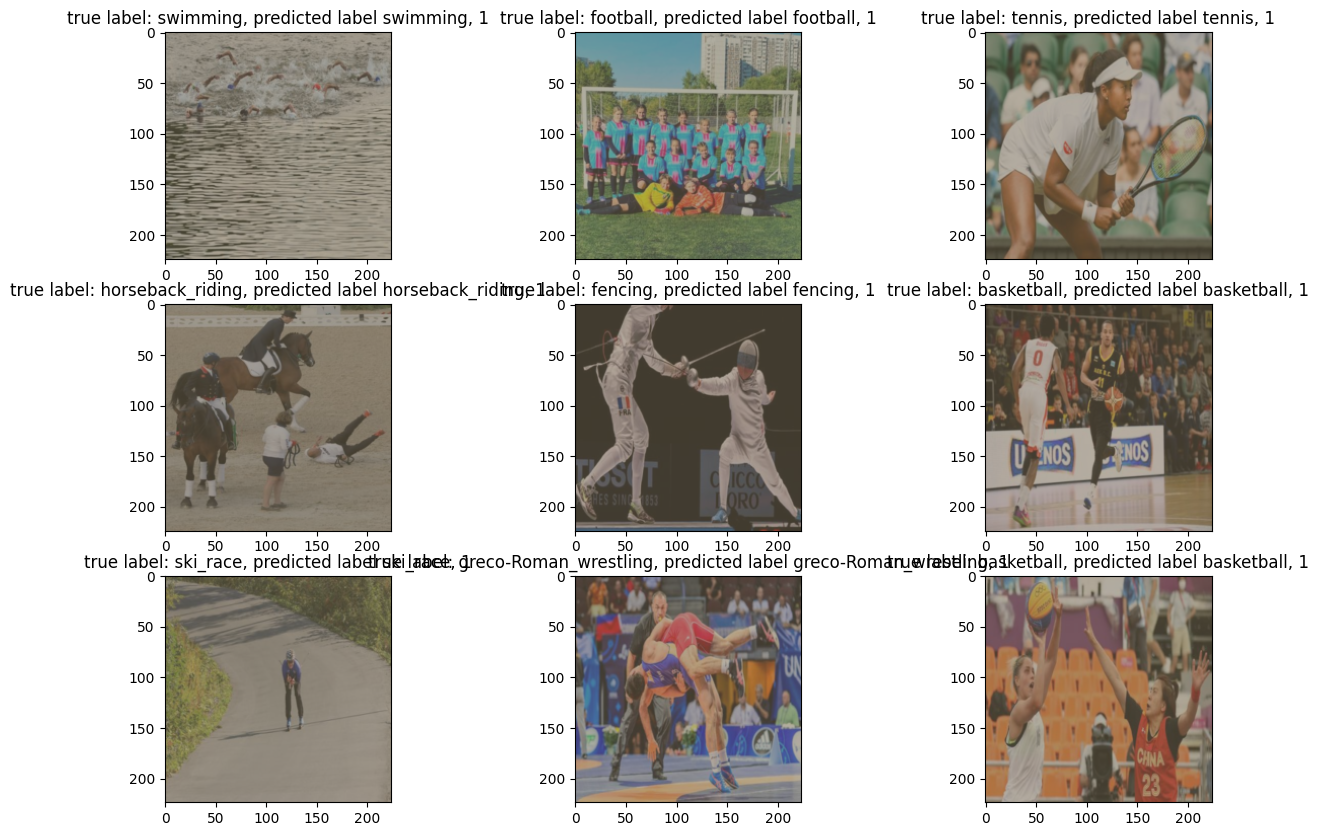

In [369]:
f, ax = plt.subplots(3, 3)
f.set_size_inches(15,10)
my_vit.eval()
with torch.no_grad():
    for i, index in enumerate(np.random.choice(len(validation_set), 9)):
        image, label = validation_set[index]
#         image = image.cuda()
        logits = my_vit(image[None, :])
        indx = torch.argmax(logits).item()
        res = index_to_label[indx]

        image = np.transpose(image.cpu().numpy(), [1, 2, 0])
        src = np.array([0.2290, 0.2240, 0.2250]) * image + np.array([0.4850, 0.4560, 0.4060])
        ax[i // 3, i % 3].imshow(src)
        ax[i // 3, i % 3].set_title(f'true label: {index_to_label[label]}, predicted label {res}, {int(index_to_label[label] == res)}')

In [371]:
%%time
test_set = SportDatasetVit(df_test, feature_extractor, is_train=False)

reading data
0
10000
data read
CPU times: user 1h 54min 40s, sys: 43.3 s, total: 1h 55min 24s
Wall time: 2min 21s


In [379]:
model_loaded = MyViT.load_from_checkpoint("./models/MyViT-16-224/MyViT-16-224-validation_score=0.929.ckpt")

In [380]:
model_loaded = model_loaded.to(1)

In [372]:
test_batch_gen = DataLoader(test_set, batch_size=128, num_workers=8, shuffle=False)

In [373]:
from tqdm import tqdm

In [374]:
predictions = []

In [382]:
new_predictions = []

Предсказание с помощью лучшей модели на валидационной выборке

In [383]:
model_loaded.eval()
with torch.no_grad():
    for tensor in tqdm(test_batch_gen, total=len(test_set) // 128):
        tensor = tensor.cuda()
        logits = model_loaded(tensor)
        indxes = torch.argmax(logits, dim=1)
        for indx in indxes:
            res = index_to_label[indx.item()]
            new_predictions.append(res)

152it [02:58,  1.18s/it]                         


In [376]:
my_vit = my_vit.to(1)

Предсказание модели, которая была чуть переобучена на обучающей выборке

In [377]:
my_vit.eval()
with torch.no_grad():
    for tensor in tqdm(test_batch_gen, total=len(test_set) // 128):
        tensor = tensor.cuda()
        logits = my_vit(tensor)
        indxes = torch.argmax(logits, dim=1)
        for indx in indxes:
            res = index_to_label[indx.item()]
            predictions.append(res)

152it [02:49,  1.11s/it]                         


In [384]:
df_test['label_vit_best'] = new_predictions

In [385]:
df_test['label_vit_last'] = predictions

Сохранение предсказаний переобученной модели 

In [420]:
df_test_last = df_test.loc[:, ['image_id', 'label_vit_last']]

In [424]:
df_test_last.columns = ['image_id', 'label']

In [425]:
df_test_last.head()

image_id       label
0  00fd3c23-193c-480a-aef9-bb438d50d79e.jpeg    ski_race
1  ef5473b9-a558-4f38-acd0-be4ecfde5a23.jpeg  basketball
2  ba00f9b4-7cbf-4110-91ea-ed41f5cb4ee4.jpeg    alpinism
3  f1bdf877-4379-4e00-b5b8-1e90bdcbda76.jpeg      tennis
4  4c96ff83-07e3-45a4-934f-a92ebf49b299.jpeg     fencing

In [431]:
df_test_last.to_csv('prediction_vit_16_224_last.csv', index=False)

Сохранение предсказаний лучшей модели

In [427]:
df_test_best = df_test.loc[:, ['image_id', 'label_vit_best']]

In [430]:
df_test_best.columns = ['image_id', 'label']

In [432]:
df_test_best.to_csv('prediction_vit_16_224_best.csv', index=False)

In [423]:
df_test.head()

image_id       label label_vit_best  \
0  00fd3c23-193c-480a-aef9-bb438d50d79e.jpeg     boating       ski_race   
1  ef5473b9-a558-4f38-acd0-be4ecfde5a23.jpeg  basketball     basketball   
2  ba00f9b4-7cbf-4110-91ea-ed41f5cb4ee4.jpeg    alpinism       alpinism   
3  f1bdf877-4379-4e00-b5b8-1e90bdcbda76.jpeg      tennis         tennis   
4  4c96ff83-07e3-45a4-934f-a92ebf49b299.jpeg     fencing        fencing   

  label_vit_last  
0       ski_race  
1     basketball  
2       alpinism  
3         tennis  
4        fencing